<a href="https://colab.research.google.com/github/ranadeepbhuyan/cancer-mri-analysis/blob/main/iegduck/DUCK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import nibabel as nib
import os
import nibabel as nib

In [ ]:
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
Data_path = r"/content/drive/MyDrive/PKG - UPENN-GBM NIfTI files/NIfTI-files/images_structural" +"/"

In [ ]:
Mask_path = r"/content/drive/MyDrive/PKG - UPENN-GBM NIfTI files/NIfTI-files/automated_segm" +"/"

In [ ]:
#fatching ids form data path
def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x


train_data_ids = [f.path for f in os.scandir(Data_path)]

training_data_ids = pathListIntoIds(train_data_ids);

In [ ]:
mask_data_ids = [f.path for f in os.scandir(Mask_path)]

mask_ids = pathListIntoIds(mask_data_ids);

In [ ]:
mask_ids.sort()
training_data_ids.sort()

In [ ]:
ids = []
for i in range(len(mask_ids)):
  test = mask_ids[i].split('_automated_approx_segm.nii')[0]
  ids.append(test)


In [ ]:
data_ids = []
for i in range(len(ids)):
  if ids[i] in training_data_ids:
    data_ids.append(ids[i])

In [ ]:
len(data_ids)

611

In [ ]:
only = []
for i in range(0,10):
  only.append(data_ids[i])

In [ ]:
train_test_ids, val_ids = train_test_split(only,test_size=0.2)
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15)

In [ ]:
VOLUME_SLICES = 10
IMG_SIZE = 128
required_shape = (IMG_SIZE,IMG_SIZE,IMG_SIZE)

In [ ]:
def add_padding(img_data, required_shape):
    # Ensure the dimensions of required_shape are (height, width, channels)
    required_height, required_width, required_length = required_shape

    # Calculate the amount of padding required on each side
    pad_x = required_height - img_data.shape[0]
    pad_y = required_width - img_data.shape[1]
    pad_z = required_length - img_data.shape[2]
    # Check if padding is needed
    if pad_x > 0 or pad_y > 0 or pad_z>0 :
        # Calculate the padding values for the top, bottom, left, and right sides
        pad_top = max(pad_x // 2, 0)
        pad_bottom = pad_x - pad_top
        pad_left = max(pad_y // 2, 0)
        pad_right = pad_y - pad_left
        pad_up = max(pad_z // 2, 0)
        pad_down = pad_z - pad_up

        # Create an empty array with the required shape
        padded_data = np.zeros((required_height, required_width, required_length), dtype=img_data.dtype)

        # Copy the original image data into the center of the padded array
        padded_data[pad_top:pad_top+img_data.shape[0], pad_left:pad_left+img_data.shape[1],pad_up:pad_up+img_data.shape[2]] = img_data
    else:
        # No padding needed; return the original image
        padded_data = img_data

    return padded_data


In [ ]:
data_path1 = os.path.join(Data_path, f'{data_ids[0]}/{data_ids[0]}_T1GD.nii');
t1gd_data = nib.load(data_path1).get_fdata()

data_path1 = os.path.join(Mask_path, f'{data_ids[0]}_automated_approx_segm.nii');
seg_data = nib.load(data_path1).get_fdata()


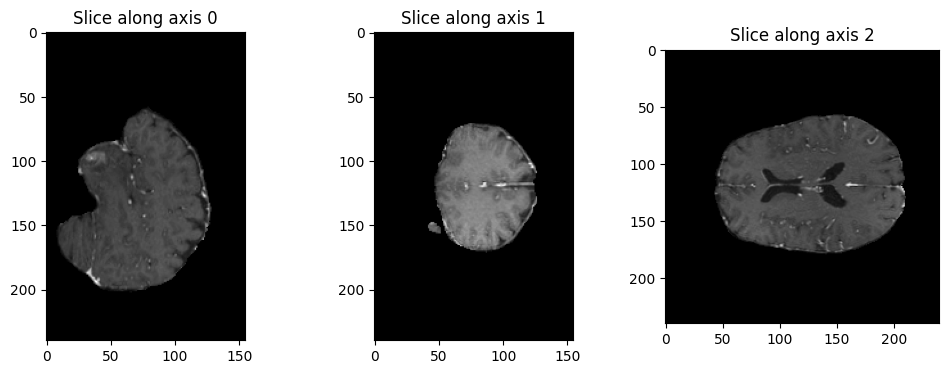

In [ ]:
# Function to display slices of the 3D image
def show_slices(image):
    # Calculate the middle index along the first axis
    middle_slice_index = image.shape[0] // 3

    # Plot the slices along the first axis
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(image[middle_slice_index, :, :], cmap='gray')
    axes[0].set_title('Slice along axis 0')

    # Plot the slices along the second axis
    axes[1].imshow(image[:, middle_slice_index, :], cmap='gray')
    axes[1].set_title('Slice along axis 1')

    # Plot the slices along the third axis
    axes[2].imshow(image[:, :, middle_slice_index], cmap='gray')
    axes[2].set_title('Slice along axis 2')

    # Display the plots
    plt.show()

# Display slices of the 3D image
show_slices(t1gd_data)


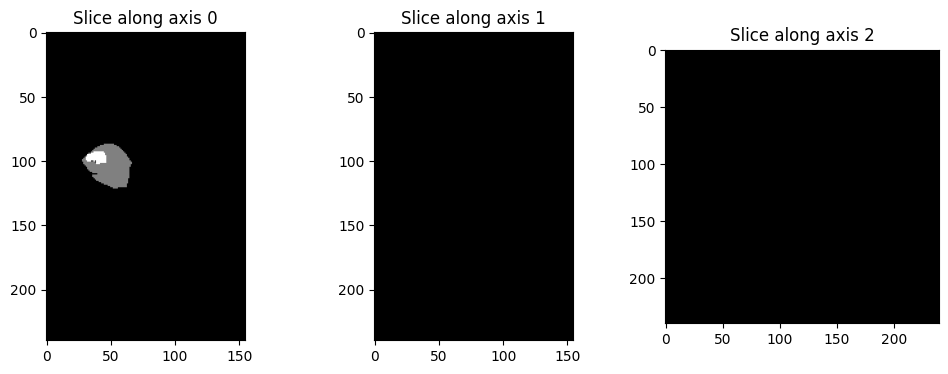

In [ ]:
show_slices(seg_data)


In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 3, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim))
              # Generate data
        for c, i in enumerate(Batch_ids):
            data_path1 = os.path.join(Data_path, f'{i}/{i}_FLAIR.nii');
            flair_data = nib.load(data_path1).get_fdata()
            flair = add_padding(flair_data, required_shape)

            data_path1 = os.path.join(Data_path, f'{i}/{i}_T1GD.nii');
            t1gd_data = nib.load(data_path1).get_fdata()
            t1gd = add_padding(t1gd_data, required_shape)

            data_path1 =  os.path.join(Data_path, f'{i}/{i}_T2.nii');
            t2_data = nib.load(data_path1).get_fdata()
            t2 = add_padding(t2_data, required_shape)

            data_path1 = os.path.join(Mask_path, f'{i}_automated_approx_segm.nii');
            seg_data = nib.load(data_path1).get_fdata()
            seg = add_padding(seg_data, required_shape)

            slice_w = 25

            for j in range(VOLUME_SLICES):
                X[j +VOLUME_SLICES*c,:,:,:,0] = cv2.resize(flair[:,:,flair.shape[0]//4 +j], (IMG_SIZE, IMG_SIZE));
                X[j +VOLUME_SLICES*c,:,:,:,1] = cv2.resize(t1gd[:,:,t1gd.shape[0]//4 +j], (IMG_SIZE, IMG_SIZE));
                X[j +VOLUME_SLICES*c,:,:,:,2] = cv2.resize(t2[:,:,t2.shape[0]//4 +j], (IMG_SIZE, IMG_SIZE));

                Y[j +VOLUME_SLICES*c,:,:,:] = cv2.resize(seg[:,:,seg.shape[0]//4 +j], (IMG_SIZE, IMG_SIZE));


        Y[Y==4] = 3;
        mask = tf.one_hot(Y, 4);

        return X/np.max(X), mask

In [ ]:
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

In [ ]:
def residual_block(input,nfilters):
  conv1 = Conv3D(filters=nfilters, kernel_size=(3, 3, 3), padding='same', kernel_initializer='he_normal')(input)
  conv1 = BatchNormalization()(conv1)
  conv2 = Conv3D(filters=nfilters, kernel_size=(3, 3, 3), padding='same', kernel_initializer='he_normal')(conv1)
  conv2 = BatchNormalization()(conv2)

  conv3 = Conv3D(filters=nfilters, kernel_size=(1, 1, 1), padding='same', kernel_initializer='he_normal')(input)
  conv3 = BatchNormalization()(conv3)

  y = Add()([conv2, conv3])
  y = BatchNormalization()(y)

  return y

In [ ]:
def midscope_block(input,nfilters):
  conv1 = Conv3D(filters=nfilters, kernel_size=(3, 3, 3), padding='same', kernel_initializer='he_normal')(input)
  conv1 = BatchNormalization()(conv1)
  conv2 = Conv3D(filters=nfilters, kernel_size=(3, 3, 3),dilation_rate=(2, 2, 2), padding='same', kernel_initializer='he_normal')(conv1)
  conv2 = BatchNormalization()(conv2)

  return conv2

In [ ]:
def widescope_block(input,nfilters):
  conv1 = Conv3D(filters=nfilters, kernel_size=(3, 3, 3), padding='same', kernel_initializer='he_normal')(input)
  conv1 = BatchNormalization()(conv1)
  conv2 = Conv3D(filters=nfilters, kernel_size=(3, 3, 3),dilation_rate=(2, 2, 2), padding='same', kernel_initializer='he_normal')(conv1)
  conv2 = BatchNormalization()(conv2)
  conv3 = Conv3D(filters=nfilters, kernel_size=(3, 3, 3),dilation_rate=(3, 3, 3), padding='same', kernel_initializer='he_normal')(conv2)
  conv3 = BatchNormalization()(conv3)

  return conv3

In [ ]:
def Separated_block(input, nfilters, n):
  conv1 = Conv3D(filters=nfilters, kernel_size=(1, 1, n), padding='same', kernel_initializer='he_normal')(input)
  conv1 = BatchNormalization()(conv1)
  conv2 = Conv3D(filters=nfilters, kernel_size=(1, n, 1), padding='same', kernel_initializer='he_normal')(conv1)
  conv2 = BatchNormalization()(conv2)
  conv3 = Conv3D(filters=nfilters, kernel_size=(n, 1, 1), padding='same', kernel_initializer='he_normal')(conv2)
  conv3 = BatchNormalization()(conv3)

  return conv3

In [ ]:
def IEG(input, nfilters):
  conv1 = Conv3D(filters=nfilters, kernel_size=(3, 3, 3),dilation_rate=(3, 3, 3), padding='same', kernel_initializer='he_normal')(input)
  conv1 = BatchNormalization()(conv1)
  conv2 = Conv3D(filters=nfilters, kernel_size=(3, 3, 3),dilation_rate=(3, 3, 3), padding='same', kernel_initializer='he_normal')(conv1)

  conv3 = Conv3D(filters=nfilters, kernel_size=(3, 3, 3),dilation_rate=(3, 3, 3), padding='same', kernel_initializer='he_normal')(input)
  conv3 = BatchNormalization()(conv3)

  add_conv = Add()([conv2, conv3])

  return add_conv

In [ ]:
def duck_block(input,nfilters):

  norml = BatchNormalization()(input,nfilters)
  #widblck = widescope_block(norml,nfilters)
  #midblck = midscope_block(norml,nfilters)

  resblck1 = residual_block(norml,nfilters)

  resblck2 = residual_block(norml,nfilters)
  resblck3 = residual_block(resblck2,nfilters)

  addblck = Add()([resblck1, resblck3])

  #residual_block1 = residual_block(norml, nfilters)
  #residual_block2 = residual_block(residual_block1, nfilters)
  #residual_block3 = residual_block(residual_block2, nfilters)

  sepblck = Separated_block(norml,nfilters,6)

  #addblck2 = Add()([widblck, midblck])

  #addblck3 = Add()([addblck2, addblck])

  #addblck4 = Add()([residual_block3, sepblck])

  addblck5 = Add()([addblck, sepblck])

  output = BatchNormalization()(addblck5)

  return output


In [ ]:
def DUCKnet(img_height, img_width, img_length, nclasses=None):

    def encoder_block(input_tensor, nfilters):

        x = Conv3D(filters=nfilters, kernel_size=(3, 3, 3), strides=(2, 2, 2), padding='same', kernel_initializer='he_normal')(input_tensor)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        return x


    def decoder_block(input_tensor, nfilters):

        x = Conv3DTranspose(filters=nfilters, kernel_size=(3, 3, 3), strides=(2, 2, 2), padding='same', kernel_initializer='he_normal')(input_tensor)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        return x

    #f is number of filters
    f = 4
    #initial block
    input_layer = Input(shape=(img_height, img_width, img_length, 3))
    ducky = duck_block(input_layer, f)

    # 1st encoder
    encoder_1 = encoder_block(input_layer, f*2)
    encoder_duck_1 = encoder_block(ducky, f*2)
    encoder_add_1 = Add()([encoder_1, encoder_duck_1])
    encoder_duck_add_1 = duck_block(encoder_add_1, f*2)

    # 2nd encoder
    encoder_2 = encoder_block(encoder_1, f*4)
    encoder_duck_2 = encoder_block(encoder_duck_add_1, f*4)
    encoder_add_2 = Add()([encoder_2, encoder_duck_2])
    encoder_duck_add_2 = duck_block(encoder_add_2, f*4)

    # 3rd encoder
    encoder_3 = encoder_block(encoder_2, f*8)
    encoder_duck_3 = encoder_block(encoder_duck_add_2, f*8)
    encoder_add_3 = Add()([encoder_3, encoder_duck_3])
    encoder_duck_add_3 = duck_block(encoder_add_3, f*8)

    # 4th encoder
    encoder_4 = encoder_block(encoder_3, f*16)
    encoder_duck_4 = encoder_block(encoder_duck_add_3, f*16)
    encoder_add_4 = Add()([encoder_4, encoder_duck_4])
    encoder_duck_add_4 = duck_block(encoder_add_4, f*16)

    #bottom layer
    bottom_layer1 = encoder_block(encoder_4, f*32)
    bottom_layer2 = encoder_block(encoder_duck_add_4, f*32)
    bottom_layer = Add()([bottom_layer1, bottom_layer2])
    resblock1 = residual_block(bottom_layer, f*32)
    resblock2 = residual_block(resblock1, f*16)

    #4th decode
    decode_4 = decoder_block(resblock2, f*16)
    decode_add_4 = Add()([decode_4, encoder_duck_add_4])
    decode_duck_4 = duck_block(decode_add_4, f*8)

    #3rd decode
    decode_3 = decoder_block(decode_duck_4, f*8)
    decode_add_3 = Add()([decode_3, encoder_duck_add_3])
    decode_duck_3 = duck_block(decode_add_3, f*4)

    #2nd decode
    decode_2 = decoder_block(decode_duck_3, f*4)
    decode_add_2 = Add()([decode_2, encoder_duck_add_2])
    decode_duck_2 = duck_block(decode_add_2, f*2)

    #1st decode
    decode_1 = decoder_block(decode_duck_2, f*2)
    decode_add_1 = Add()([decode_1, encoder_duck_add_1])
    decode_duck_1 = duck_block(decode_add_1, f)

    #final layer
    final_layer = decoder_block(decode_duck_1, f)
    final_layer_add = Add()([final_layer, ducky])
    final_layer_duck = duck_block(final_layer_add, f)

    final_output = Conv3DTranspose(filters=nclasses, kernel_size=(1, 1, 1), padding='same', kernel_initializer='he_normal')(final_layer_duck)

    output_layer = Activation('softmax')(final_output)

    model = Model(inputs=input_layer, outputs=output_layer, name='DUCKnet')
    return model

In [ ]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss

    total_loss = total_loss / class_num
    return total_loss

In [ ]:
def mean_iou(y_true, y_pred, smooth=1.0):
    class_num = 4
    iou_total = 0

    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,:,i])

        intersection = K.sum(K.abs(y_true_f * y_pred_f))
        union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection

        iou = (intersection + smooth) / (union + smooth)
        iou_total += iou

    mean_iou = iou_total / class_num
    return mean_iou


In [ ]:
model = DUCKnet(IMG_SIZE, IMG_SIZE, IMG_SIZE, nclasses=4)
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',mean_iou, dice_coef] )

In [ ]:
model.summary()

Model: "DUCKnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 12  12         ['input_1[0][0]']                
 alization)                     8, 3)                                                             
                                                                                                  
 conv3d_3 (Conv3D)              (None, 128, 128, 12  328         ['batch_normalization[0][0]']    
                                8, 4)                                                       

In [ ]:
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=15
                             )
checkpointer = ModelCheckpoint(filepath="Ducknet.hdf5",
                               verbose=1,
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=5,
                              min_delta=0.0001,
                              factor=0.2
                             )

history =  model.fit(training_generator,
                    epochs=10,
                    steps_per_epoch=len(train_ids),
                    callbacks= [checkpointer, reduce_lr, earlystopping],
                    validation_data = valid_generator
                    )

Epoch 1/10
6/6 [==============================] - ETA: 0s - loss: 1.7091 - accuracy: 0.1876 - mean_iou: 0.0651 - dice_coef: 0.1052  
Epoch 1: val_loss improved from inf to 3.66471, saving model to Ducknet.hdf5
6/6 [==============================] - 799s 124s/step - loss: 1.7091 - accuracy: 0.1876 - mean_iou: 0.0651 - dice_coef: 0.1052 - val_loss: 3.6647 - val_accuracy: 0.3123 - val_mean_iou: 0.0748 - val_dice_coef: 0.1161 - lr: 0.0010
Epoch 2/10
6/6 [==============================] - ETA: 0s - loss: 1.5576 - accuracy: 0.2629 - mean_iou: 0.0692 - dice_coef: 0.1104  
Epoch 2: val_loss improved from 3.66471 to 3.46419, saving model to Ducknet.hdf5
6/6 [==============================] - 724s 121s/step - loss: 1.5576 - accuracy: 0.2629 - mean_iou: 0.0692 - dice_coef: 0.1104 - val_loss: 3.4642 - val_accuracy: 0.6461 - val_mean_iou: 0.1214 - val_dice_coef: 0.1651 - lr: 0.0010
Epoch 3/10
6/6 [==============================] - ETA: 0s - loss: 1.4730 - accuracy: 0.4774 - mean_iou: 0.0729 - dice_